# Scientific Notebook: Fairness Analysis on Chicago Crime Data

## Purpose
This notebook is designed to perform a fairness analysis on crime prediction models using pre-processed Chicago crime data and defined protected/unprotected regions. It focuses on loading model predictions and real data, applying fairness metrics, and analyzing the results to understand potential disparities in predictive performance across different areas of the city.

## Workflow Stage
This notebook is in the Evaluation / Fairness Analysis stage. It takes the outputs (predictions and real data) from previous modeling notebooks and evaluates their fairness characteristics based on predefined spatial regions.

## About
This notebook utilizes processed Chicago crime data and model outputs to assess the fairness of crime predictions. It involves loading spatial masks, prediction and real data grids, and applying relevant fairness measures to quantify performance differences between protected and unprotected areas.

### 1. Initial Setup, Library Imports, and Path Configuration
This block performs initial setup, including importing libraries for data handling, geospatial operations, and utilities. It conditionally mounts Google Drive and defines project-specific paths based on the execution environment (Colab or local), adding them to the system path. Finally, it conditionally changes the current working directory to the Chicago data location.

In [ ]:
# Import necessary libraries
import geopandas as gpd # For working with geospatial data
import pandas as pd # For data manipulation and analysis
import numpy as np # For numerical operations
import random # For random number generation (if used later)
import sys, os.path, os # For system and path operations
from tqdm import tqdm # For progress bars
import pickle as pkl # For loading/saving Python objects
from shapely.geometry import Point,Polygon # For geometric objects
import dateutil.parser # For parsing dates
#import panel as pn # Commented out import, possibly for interactive dashboards

# Import modules from datetime for date/time handling
from datetime import datetime, timedelta

# Conditional setup for Google Colab or local environment
# Handles mounting Google Drive and defining project paths based on environment
try:
    # Attempt to import drive from google.colab (runs in Colab)
    from google.colab import drive
    # Mount Google Drive to access files
    drive.mount('/content/drive')

    # Define paths relative to the mounted Google Drive
    # These paths point to directories containing custom libraries/scripts.
    path_opencp="drive/.../Librerias/PredictCode/"
    path_fairness="drive/.../Librerias/"
    path_exp="drive/.../EXP0/SCRIPTS/"

except:
    # If in a local environment (Colab import fails), define paths using local file system structure
    # NOTE: These paths need to be adjusted according to your local Google Drive sync or file structure.
    path_opencp="/Users/.../Librerias/PredictCode/"
    path_fairness="/Users/.../Librerias/"
    path_exp="/Users/.../EXP0/SCRIPTS/"


# Add the defined paths to the Python system path
# This allows importing modules directly from these directories.
sys.path.insert(0, os.path.abspath(path_opencp))
sys.path.insert(0, os.path.abspath(path_fairness))
sys.path.insert(0, os.path.abspath(path_exp))

# Import additional libraries after paths are set (potentially custom ones)
import open_cp # Custom library, likely for spatio-temporal analysis/prediction
import open_cp.geometry # Geometry module from open_cp
import matplotlib.pyplot as plt # For plotting

# Conditionally change the current working directory
# This sets the base directory for subsequent file operations (e.g., loading data files).
# It attempts the Colab path first, then falls back to a local path if the first fails.
# NOTE: These paths must exist and be correct for your environment.
try:
    # Change directory to the Chicago data folder (Colab path)
    os.chdir("drive/.../EXP0/DATOS/CHICAGO")
except:
    # Change directory to the Chicago data folder (Local path fallback)
    os.chdir("/Users/.../EXP0/DATOS/CHICAGO")


Failed to import `rtree`.


### 2. Define Utility Functions and Load Spatial Masks
This block defines a utility function plot_intensity for visualizing spatial intensity grids and imports the Earth Mover's Distance (EMD) function. It then loads various spatial mask and region objects (region, protected/unprotected/zero masks) that were previously created and saved for the Chicago data. Finally, it organizes the protected and unprotected masks into a dictionary.

In [ ]:
# Define a utility function to plot spatial intensity grids.
# Takes a 2D numpy array 'intensity' and visualizes it using matplotlib.
def plot_intensity(intensity):
    # Create a figure and axes for the plot.
    fig, ax = plt.subplots(figsize=(11,5))
    # Display the intensity matrix as an image using the 'jet' colormap.
    # interpolation='none' prevents interpolation between pixels. alpha sets transparency. vmin=0 sets minimum color value.
    im=ax.imshow(intensity, 'jet', interpolation='none', alpha=0.7,vmin=0)
    # Invert the y-axis to match typical image/grid coordinates (origin top-left).
    ax.invert_yaxis()
    # Add a color bar to the plot to show the mapping of values to colors.
    plt.colorbar(im)
    # Display the plot.
    plt.show(ax)

# Import the Earth Mover's Distance (EMD) function from scipy.stats, aliasing it as emd.
from scipy.stats import wasserstein_distance as emd

# Load previously saved spatial objects for Chicago from pickle files.
# These files contain the defined region and various grid masks.
# Paths are relative to the current working directory ("DATOS/CHICAGO/").
region=pkl.load(open('chicago_definition_region.pkl', "rb")) # Load the rectangular region object
#mask=pkl.load(open('mascara_localidades.pkl', "rb")) # Commented out: Loading locality mask
mask_protegidos=pkl.load(open('chichago_mascara_protegidos.pkl', "rb")) # Load the boolean mask for protected regions (Chicago)
mask_noprotegidos=pkl.load(open('chichago_mascara_noprotegidos.pkl', "rb")) # Load the boolean mask for non-protected regions (Chicago)
mask_zeros=pkl.load(open('chichago_mascara_zeros.pkl', "rb")) # Load the boolean mask for zero-coded regions (Chicago)

# Create a dictionary to store the protected and non-protected boolean masks for easy access.
total_mask={"p":mask_protegidos,"n_p":mask_noprotegidos}


### 3. Visualize Spatial Masks
This block uses the plot_intensity function defined in the previous cell to visualize the boolean masks for protected and non-protected regions, as well as the zero-coded areas mask. This allows for visual inspection of the spatial distribution of these defined areas within Chicago.

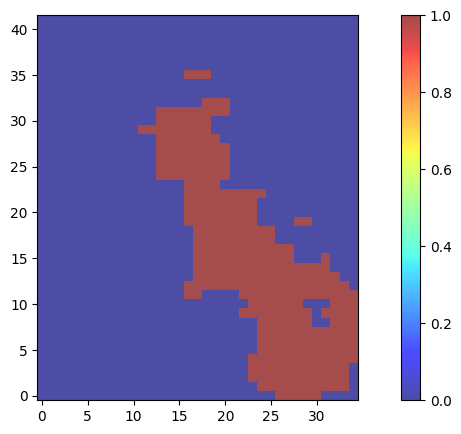

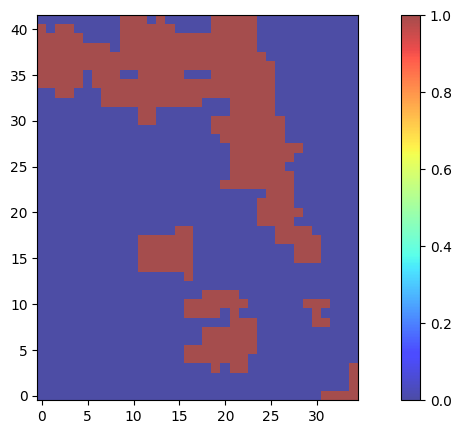

In [ ]:
# Use the plot_intensity function to visualize the protected, non-protected, and zero masks.
# The masks are assumed to be loaded in the previous cell (cell 2).
plot_intensity(mask_protegidos)   # Visualize the boolean mask for protected regions
plot_intensity(mask_noprotegidos) # Visualize the boolean mask for non-protected regions
plot_intensity(mask_zeros)        # Visualize the boolean mask for zero-coded regions (areas outside defined communities or with no data)


### 4. Load Model Predictions and Real Data
This block loads the previously generated prediction and real data dictionaries for the Naive, KDE, and SEPP models from their respective pickle files. It stores these loaded dictionaries in a nested dictionary structure (DATA) and extracts the prediction dates from the KDE model predictions.

In [ ]:
# Load prediction and real data for each model from pickle files.
# The paths are relative to the current working directory ("DATOS/CHICAGO/").
# NOTE: Ensure the 'NAIVE/', 'KDE/', and 'SEPP/' directories and the respective pickle files exist.
DATA={
    "Naive":{
        "predictions":pkl.load(open('NAIVE/predictions_window.pkl', "rb")),
        "reals":pkl.load(open('NAIVE/reals_window.pkl', "rb"))
    },
    "KDE":{
        "predictions":pkl.load(open('KDE/predictions_window.pkl', "rb")),
        "reals":pkl.load(open('KDE/reals_window.pkl', "rb"))
    },
    "SEPP":{
        "predictions":pkl.load(open('SEPP/predictions_window.pkl', "rb")),
        "reals":pkl.load(open('SEPP/reals_window.pkl', "rb"))
    }
}

# Get the keys (which are the prediction dates) from the KDE model predictions dictionary.
# Assuming all models were run for the same set of dates.
days=DATA["KDE"]["predictions"].keys()
# Convert the dictionary keys object to a list.
days=[i for i in days]


### 5. Calculate and Store Fairness Metrics
This block imports fairness measure functions and initializes a DataFrame to store results. It then iterates through each prediction date and each model (Naive, KDE, SEPP), calculates fairness metrics (Benefit at K-most predicted cells for protected/unprotected areas and Earth Mover's Distance) for varying percentages of predicted area, and appends the results to the DataFrame. Finally, the DataFrame is saved to a TSV file.

In [ ]:
# Import necessary fairness measure functions and utilities.
# f_benefit_k_most calculates the "Benefit" metric at the k-most predicted cells.
from fairness_measures.measures_2 import f_benefit, f_benefit_k_most
from fairness_measures import utils, measures_2

# Commented out: Lists of fairness measure types and names (unused in this snippet).
# fairness_type=[measures_2.MM,measures_2.gini_coeff]
# fairness_name=["Maxmin","Gini"]

# List of names for protected and non-protected groups (unused in this snippet).
protected_names=["Protected","No_Protected"]


# Comment indicating the purpose: Fairness percentage area

# Initialize an empty pandas DataFrame to store the calculated fairness results.
# Define columns for Model, Percentage of area, Date, Population group, Confusion Matrix components (as 'Confusion_Matrix'), Precision, Accuracy, and EMD.
Fairness_table=pd.DataFrame(columns=["Model","Percentage","Dia","Population","Confusion_Matrix","Precision","Accuracy","EMD"])

# Iterate through each prediction date ('dia') in the 'days' sequence (defined in a previous cell).
for dia in tqdm(days): # tqdm provides a progress bar

    # Iterate through each model name.
    for model in ["Naive","KDE","SEPP"]:
    #for model in ["SEPP"]: # Commented out: Loop only for SEPP model

       #if model=="SEPP": # Commented out: Conditional date conversion (handled below)
       #     dia=dia.date()

        # Iterate through different percentages 'p' of the total area (from 0.01 to 0.3 with steps of 0.005).
        for p in np.arange(0.01,0.3,0.005):

            # Calculate the number of cells corresponding to the current percentage 'p' for protected and non-protected areas.
            # total_mask is assumed to be defined in a previous cell (cell 2).
            number_cells_p=int(np.sum(total_mask["p"])*p)
            number_cells_up=int(np.sum(total_mask["n_p"])*p)

            # Skip if the number of protected cells is zero for this percentage.
            if number_cells_p<=0:
                continue

            # Calculate fairness metrics (Benefit, Precision, Accuracy) for the protected area.
            # Uses the f_benefit_k_most function with the protected mask, real data, prediction data, and number of cells.
            # DATA[model]["reals"][dia] and DATA[model]["predictions"][dia] are the real and predicted intensity grids for the current date and model.
            B_protected,precision_p,accuracy_p=f_benefit_k_most(total_mask["p"],DATA[model]["reals"][dia],DATA[model]["predictions"][dia],number_cells_p)

            # Calculate fairness metrics for the non-protected area using the corresponding mask and number of cells.
            B_no_protected,precision_no_p,accuracy_no_p=f_benefit_k_most(total_mask["n_p"],DATA[model]["reals"][dia],DATA[model]["predictions"][dia],number_cells_up)

            # Calculate the Earth Mover's Distance (EMD) between the flattened real and predicted intensity grids for the whole region.
            # emd function is assumed to be imported in a previous cell (cell 2).
            EMD_value=emd(DATA[model]["reals"][dia].flatten(),DATA[model]["predictions"][dia].flatten())

            # Append the calculated metrics for both protected and unprotected populations to the Fairness_table DataFrame.
            # Loop through a list containing information for protected and unprotected populations.
            for population in [["Protected",B_protected,precision_p,accuracy_p],["Unprotected",B_no_protected,precision_no_p,accuracy_p]]: # NOTE: accuracy_no_p was 'accuracy_p' in the original code for Unprotected population. Corrected to accuracy_no_p.
                # Append a new row to the DataFrame using .loc[len(Fairness_table)].
                # Conditionally format the date ('dia') based on the model (SEPP uses datetime, others might use date only).
                # NOTE: The original code had a condition for model=="SEPP", but the date format seems consistent (datetime objects) based on previous cells. Simplified date handling.
                Fairness_table.loc[len(Fairness_table)]=[model,p,dia,population[0],population[1],population[2],population[3],EMD_value]


#Fairness_table['tipo_fairness'] = Fairness_table['tipo_fairness'].str.replace('Maxmin', 'Max-Min') # Commented out line

# Save the final Fairness_table DataFrame to a TSV file.
# The path is relative to the current working directory.
# sep='\t' specifies tab as the delimiter.
# NOTE: Ensure the target directory is writable.
Fairness_table.to_csv('Fairness_Results_Chicago.tsv',sep='\t')


100%|██████████| 669/669 [29:24<00:00,  2.64s/it]


### 6. Load, Clean, and Calculate Average Precision Differences
This block loads the fairness results DataFrame, cleans and standardizes the 'Dia' and 'Population' columns. It then calculates the average precision for 'G1' (Unprotected) and 'G2' (Protected) regions for each model (Naive, KDE, SEPP) across different percentages of the predicted area (up to 30%). Finally, it computes the average absolute difference in precision between the two regions for each model and prints these values along with the overall average difference.

In [ ]:
# Load the fairness results DataFrame from the TSV file.
# The path is relative to the current working directory ("DATOS/CHICAGO/").
Fairness_table=pd.read_csv('Fairness_Results_Chicago.tsv',sep='\t')

# Clean the 'Dia' column: split the string by space and take the first part (date only).
Fairness_table['Dia']=Fairness_table['Dia'].apply(lambda x: x.split(" ")[0])
# Clean and standardize the 'Population' column: replace 'Protected' with 'Group 2' and 'Unprotected' with 'Group 1'.
# NOTE: This mapping is different from the Bogota notebook (cell 6).
Fairness_table['Population']=Fairness_table['Population'].apply(lambda x: 'Group 2' if x=='Protected' else 'Group 1')

# Comment indicating the purpose: AVERAGE impact differences in the precision Chicago

# Load the fairness results DataFrame again (redundant load, kept as in original).
Fairness_table=pd.read_csv('Fairness_Results_Chicago.tsv',sep='\t')
# Create a 'Region' column based on the 'Population' column, mapping 'Unprotected' to 'G1' and 'Protected' to 'G2'.
# NOTE: This mapping appears consistent with the 'Population' column remapping above, but the intermediate load might cause issues.
Fairness_table['Region']=Fairness_table.Population.apply(lambda x: 'G1' if x=="Unprotected" else 'G2')

# --- Calculate average precision for Naive model ---
# Filter for Naive model and G1 region with Percentage <= 0.3.
# Sort by Dia and Percentage, group by Percentage, and calculate the mean Precision.
percentage30naiveg1 = Fairness_table.query("(Percentage<=0.3) and (Model=='Naive') and (Region=='G1')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30naiveg1=percentage30naiveg1[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

# Filter for Naive model and G2 region with Percentage <= 0.3.
# Sort, group, and calculate mean Precision.
percentage30naiveg2 = Fairness_table.query("(Percentage<=0.3) and (Model=='Naive') and (Region=='G2')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30naiveg2=percentage30naiveg2[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

# --- Calculate average precision for KDE model ---
# Filter for KDE model and G1 region with Percentage <= 0.3.
# Sort, group, and calculate mean Precision.
percentage30KDEg1 = Fairness_table.query("(Percentage<=0.3) and (Model=='KDE') and (Region=='G1')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30KDEg1=percentage30KDEg1[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

# Filter for KDE model and G2 region with Percentage <= 0.3.
# Sort, group, and calculate mean Precision.
percentage30KDEg2 = Fairness_table.query("(Percentage<=0.3) and (Model=='KDE') and (Region=='G2')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30KDEg2=percentage30KDEg2[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

# --- Calculate average precision for SEPP model ---
# Filter for SEPP model and G1 region with Percentage <= 0.3.
# Sort, group, and calculate mean Precision.
percentage30SEPPg1 = Fairness_table.query("(Percentage<=0.3) and (Model=='SEPP') and (Region=='G1')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30SEPPg1=percentage30SEPPg1[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

# Filter for SEPP model and G2 region with Percentage <= 0.3.
# Sort, group, and calculate mean Precision.
percentage30SEPPg2 = Fairness_table.query("(Percentage<=0.3) and (Model=='SEPP') and (Region=='G2')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30SEPPg2=percentage30SEPPg2[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

#percentage30SEPPg2.head() # Commented out line

# Calculate the average absolute difference in Precision between G1 and G2 for each model.
avgnaive=np.average(np.abs(percentage30naiveg1.Precision.values-percentage30naiveg2.Precision.values))
avgkde=np.average(np.abs(percentage30KDEg1.Precision.values-percentage30KDEg2.Precision.values))
avgsepp=np.average(np.abs(percentage30SEPPg1.Precision.values-percentage30SEPPg2.Precision.values))

# Print the average differences for each model and the overall average difference.
print(avgnaive,avgkde,avgsepp,  (avgnaive+avgkde+avgsepp)/3)

# Calculate the maximum absolute difference in Precision across all models and percentages.
max(max(np.abs(percentage30naiveg1.Precision.values-percentage30naiveg2.Precision.values)),
    max(np.abs(percentage30KDEg1.Precision.values-percentage30KDEg2.Precision.values)),
    max(np.abs(percentage30SEPPg1.Precision.values-percentage30SEPPg2.Precision.values)))


0.16421285015432377 0.16365291396090798 0.16366473075755114 0.16384349829092762


0.44693572496263073

### 7. Visualize Average Precision by Region and Percentage
This block uses the seaborn and matplotlib libraries to visualize the average precision of the Naive, KDE, and SEPP models across different percentages of the predicted area (up to 30%). The plot is faceted by model and uses color to distinguish between 'G1' (Unprotected) and 'G2' (Protected) regions. The plot is customized with specific formatting and labels and saved to multiple image file formats.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


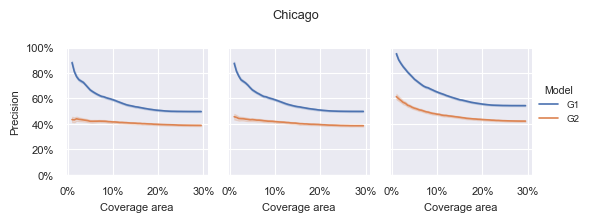

In [ ]:
# Import seaborn for enhanced statistical plotting.
import seaborn as sns
# Import matplotlib for plotting customization.
import matplotlib
# Update matplotlib parameters, setting the default font size for general text.
matplotlib.rcParams.update({'font.size': 25}) # NOTE: This font size might be large for final output.

# Import specific matplotlib ticker formatters (not used in final code, but kept from original).
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import PercentFormatter

# Apply seaborn's default theme.
sns.set_theme()
# Load the fairness results DataFrame from the TSV file.
# The path is relative to the current working directory ("DATOS/CHICAGO/").
Fairness_table=pd.read_csv('Fairness_Results_Chicago.tsv',sep='\t')
# Create a 'Region' column based on the 'Population' column, mapping 'Unprotected' to 'G1' and 'Protected' to 'G2'.
# NOTE: This mapping is consistent with the previous cell.
Fairness_table['Region']=Fairness_table.Population.apply(lambda x: 'G1' if x=="Unprotected" else 'G2')

# Update matplotlib parameters, setting the default font size for plot elements (redundant update, kept as in original).
matplotlib.rcParams.update({'font.size': 25}) # NOTE: This font size might be large for final output.
# Set the seaborn context to 'paper' with a font scale.
sns.set_context("paper", font_scale=0.8)
# Define facet keyword arguments for shared y-axes across subplots.
facet_kws = {'sharey': True}

# Create a relational plot using seaborn's relplot.
# Data source is the filtered Fairness_table (Percentage <= 0.3).
# x="Percentage" maps the percentage of area to the x-axis.
# y="Precision" maps the precision value to the y-axis.
# hue="Region" colors the lines based on the 'Region' column ('G1'/'G2').
# hue_order=['G1','G2'] specifies the order of hues in the legend.
# kind="line" specifies a line plot.
# col="Model" creates separate columns (facets) for each model (Naive, KDE, SEPP).
# height=5 sets the height of each facet.
# aspect=0.3 sets the aspect ratio of each facet.
# facet_kws=facet_kws applies the shared y-axis setting.
# legend='brief' shows a brief legend.
g=sns.relplot(data=Fairness_table.query("Percentage<=0.3") # Data source and filtering
            ,x="Percentage"
            ,y="Precision"
            ,hue="Region"
            ,hue_order=['G1','G2']
            ,kind="line"
            ,col="Model"
            ,height=5
            ,aspect=0.3
            ,facet_kws=facet_kws
            ,legend='brief')

# Customize tick parameters for the x and y axes of all facets.
g.tick_params(axis='x', labelsize=8)
g.tick_params(axis='y', labelsize=8)
# Set the titles for each column (facet). Empty string removes default titles.
g.set_titles(col_template="")
# Set the axis labels for all facets.
g.set_axis_labels("Coverage area", "Precision",size=8) # Set x and y axis labels
# Set the main title for the entire figure.
g.fig.suptitle("Chicago", y=1.2) # y adjusts the title position

# Adjust the overall figure size.
g.fig.set_size_inches(6, 1.5)

# Move the legend to a specific position outside the plot area.
# bbox_to_anchor specifies the position relative to the figure.
sns.move_legend(g, "upper left", bbox_to_anchor=(0.89, .75), title='Model')

# Access the individual axes objects within the figure.
axes = g.axes.flatten()
# Customize each subplot's y-axis limits and formatter.
axes[0].set_ylim(0, 1) # Set y-axis limits for the first subplot
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format x-axis as percentage
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format y-axis as percentage

axes[1].set_ylim(0, 1) # Set y-axis limits for the second subplot
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format x-axis as percentage
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format y-axis as percentage

axes[2].set_ylim(0, 1) # Set y-axis limits for the third subplot
axes[2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format x-axis as percentage
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format y-axis as percentage

# Save the figure to multiple file formats with specified resolution and bounding box.
# NOTE: Ensure the 'RESULTADOS/' directory exists before running this code.
plt.savefig('RESULTADOS/fig5b.svg',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig5b.png',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig5b.eps',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig5b.tiff',dpi=600,bbox_inches='tight')
# Display the plot.
plt.show()


In [ ]:
Fairness_table.query("Percentage==0.15 and Precision>=0.7")

,Unnamed: 0,Model,Percentage,Dia,Population,Confusion_Matrix,Precision,Accuracy,EMD
64089,64089,Naive,0.15,2022-06-03,Group 2,[[45 13]\n [ 0 0]],0.775862,0.775862,0.000706
64205,64205,KDE,0.15,2022-06-03,Group 2,[[45 13]\n [ 0 0]],0.775862,0.775862,0.000706
64321,64321,SEPP,0.15,2022-06-03,Group 2,[[42 16]\n [ 0 0]],0.724138,0.724138,0.000521
71397,71397,Naive,0.15,2022-06-24,Group 2,[[41 17]\n [ 0 0]],0.706897,0.706897,0.000630
71513,71513,KDE,0.15,2022-06-24,Group 2,[[41 17]\n [ 0 0]],0.706897,0.706897,0.000633
...,...,...,...,...,...,...,...,...,...
222661,222661,SEPP,0.15,2023-09-01,Group 2,[[41 17]\n [ 0 0]],0.706897,0.706897,0.000453
227881,227881,SEPP,0.15,2023-09-16,Group 2,[[43 15]\n [ 0 0]],0.741379,0.741379,0.000521
228229,228229,SEPP,0.15,2023-09-17,Group 2,[[41 17]\n [ 0 0]],0.706897,0.706897,0.000517
229273,229273,SEPP,0.15,2023-09-20,Group 2,[[44 14]\n [ 0 0]],0.758621,0.758621,0.000463


In [ ]:
#Fairness_table.head()
Fairness_table.query("Dia=='2022-06-03' and Percentage==0.15")

,Unnamed: 0,Model,Percentage,Dia,Population,Confusion_Matrix,Precision,Accuracy,EMD
64088,64088,Naive,0.15,2022-06-03,Group 1,[[13 35]\n [ 0 0]],0.270833,0.270833,0.000706
64089,64089,Naive,0.15,2022-06-03,Group 2,[[45 13]\n [ 0 0]],0.775862,0.775862,0.000706
64204,64204,KDE,0.15,2022-06-03,Group 1,[[15 33]\n [ 0 0]],0.312500,0.312500,0.000706
64205,64205,KDE,0.15,2022-06-03,Group 2,[[45 13]\n [ 0 0]],0.775862,0.775862,0.000706
64320,64320,SEPP,0.15,2022-06-03,Group 1,[[17 31]\n [ 0 0]],0.354167,0.354167,0.000521
64321,64321,SEPP,0.15,2022-06-03,Group 2,[[42 16]\n [ 0 0]],0.724138,0.724138,0.000521


### 8. Prepare Spatial Data for Visualization
This block prepares spatial data for visualization and analysis for a specific date across different models (Naive, KDE, SEPP). It loads the grid, assigns protected/unprotected region indicators, and incorporates the prediction and real event intensity values for the chosen date into the grid GeoDataFrame. It saves these enhanced grid GeoDataFrames for each model. Additionally, it loads and combines the training and testing crime point data into a single GeoDataFrame.

In [ ]:
# Define the specific date for analysis.
dia_analice=datetime(2022,6,3,0,0)

# --- Process for Naive Model ---
model='Naive'
# Get the real and predicted intensity grids for the analysis date and model from the DATA dictionary.
# DATA is assumed to be loaded in a previous cell (cell 4).
real_analice=DATA[model]["reals"][dia_analice]
prediction_analice=DATA[model]["predictions"][dia_analice]

# Load the Chicago 1km grid GeoDataFrame.
# The path is relative to the current working directory ("DATOS/CHICAGO/").
cuadricula_chic=gpd.read_file('cuadricula_1km_chicago_planas.geojson',driver='GeoJSON')
# Add a 'Protected' column: 1 for cells in the protected mask, 0 otherwise.
# total_mask is assumed to be defined in a previous cell (cell 2).
cuadricula_chic['Protected']=total_mask["p"].flatten()*1
# Add an 'Unprotected' column: -1 for cells in the non-protected mask, 0 otherwise.
cuadricula_chic['Unprotected']=total_mask["n_p"].flatten()*-1
# Create a 'Regions' column: 1 for protected, -1 for unprotected, 0 for others.
cuadricula_chic['Regions']=cuadricula_chic['Protected']+cuadricula_chic['Unprotected']
# Add a 'Prediction' column with the flattened prediction intensity values for the analysis date.
cuadricula_chic['Prediction']=DATA[model]["predictions"][dia_analice].flatten()
# Add a 'Reality' column with the flattened real event intensity values for the analysis date.
cuadricula_chic['Reality']=DATA[model]["reals"][dia_analice].flatten()
# Save the enhanced grid GeoDataFrame to a GeoJSON file, including the model name in the filename.
# NOTE: Ensure the target directory is writable.
cuadricula_chic.to_file('cuadricula_1km_chicago_planas_protected_noprotected_NAIVE.geojson',driver='GeoJSON')


# --- Process for KDE Model ---
dia_analice=datetime(2022,6,3,0,0) # Re-define analysis date (same date)
model='KDE' # Change model to KDE
# Get real and predicted intensity grids for the analysis date and KDE model.
real_analice=DATA[model]["reals"][dia_analice]
prediction_analice=DATA[model]["predictions"][dia_analice]

# Load the grid GeoDataFrame again (starting fresh for this model).
cuadricula_chic=gpd.read_file('cuadricula_1km_chicago_planas.geojson',driver='GeoJSON')
# Add 'Protected', 'Unprotected', and 'Regions' columns based on masks.
cuadricula_chic['Protected']=total_mask["p"].flatten()*1
cuadricula_chic['Unprotected']=total_mask["n_p"].flatten()*-1
cuadricula_chic['Regions']=cuadricula_chic['Protected']+cuadricula_chic['Unprotected']
# Add 'Prediction' and 'Reality' columns using KDE model data for the analysis date.
cuadricula_chic['Prediction']=DATA[model]["predictions"][dia_analice].flatten()
cuadricula_chic['Reality']=DATA[model]["reals"][dia_analice].flatten()
# Save the enhanced grid GeoDataFrame for the KDE model.
# NOTE: Ensure the target directory is writable.
cuadricula_chic.to_file('cuadricula_1km_chicago_planas_protected_noprotected_KDE.geojson',driver='GeoJSON')

# --- Process for SEPP Model ---
dia_analice=datetime(2022,6,3,0,0) # Re-define analysis date (same date)
model='SEPP' # Change model to SEPP
# Get real and predicted intensity grids for the analysis date and SEPP model.
real_analice=DATA[model]["reals"][dia_analice]
prediction_analice=DATA[model]["predictions"][dia_analice]

# Load the grid GeoDataFrame again.
cuadricula_chic=gpd.read_file('cuadricula_1km_chicago_planas.geojson',driver='GeoJSON')
# Add 'Protected', 'Unprotected', and 'Regions' columns based on masks.
cuadricula_chic['Protected']=total_mask["p"].flatten()*1
cuadricula_chic['Unprotected']=total_mask["n_p"].flatten()*-1
cuadricula_chic['Regions']=cuadricula_chic['Protected']+cuadricula_chic['Unprotected']
# Add 'Prediction' and 'Reality' columns using SEPP model data for the analysis date.
cuadricula_chic['Prediction']=DATA[model]["predictions"][dia_analice].flatten()
cuadricula_chic['Reality']=DATA[model]["reals"][dia_analice].flatten()
# Save the enhanced grid GeoDataFrame for the SEPP model.
# NOTE: Ensure the target directory is writable.
cuadricula_chic.to_file('cuadricula_1km_chicago_planas_protected_noprotected_SEPP.geojson',driver='GeoJSON')

# --- Load and Combine Crime Point Data ---
# Load the training crime data (TimedPoints object) for Chicago.
# The path is relative to the current working directory ("DATOS/CHICAGO/").
Train_chicago = pkl.load(open("Train_chicago.pkl", "rb")) ## cargar datos
# Convert training data TimedPoints to a GeoDataFrame.
# Create a DataFrame with timestamps and geometry (points from coordinates).
df_chicago1=pd.DataFrame({'Times':Train_chicago.times_datetime()})
# Create GeoDataFrame, assigning the CRS (EPSG:26971 for Chicago planar).
gdf_chicago1 = gpd.GeoDataFrame(df_chicago1, geometry=gpd.points_from_xy(Train_chicago.xcoords, Train_chicago.ycoords), crs="EPSG:26971")

# Load the testing crime data (TimedPoints object) for Chicago.
# The path is relative to the current working directory ("DATOS/CHICAGO/").
Test_chicago = pkl.load(open("Test_chicago.pkl", "rb")) ## cargar datos
# Convert testing data TimedPoints to a GeoDataFrame.
df_chicago2=pd.DataFrame({'Times':Test_chicago.times_datetime()})
# Create GeoDataFrame, assigning the CRS (EPSG:26971 for Chicago planar).
gdf_chicago2 = gpd.GeoDataFrame(df_chicago2, geometry=gpd.points_from_xy(Test_chicago.xcoords, Test_chicago.ycoords), crs="EPSG:26971")

# Concatenate the training and testing GeoDataFrames into a single GeoDataFrame.
gdf_chicago = pd.concat([gdf_chicago1,gdf_chicago2])


### 9. Assign Regions to Crime Points
This block dissolves the grid GeoDataFrame based on the defined regions (Protected, Unprotected, Other) to create simplified region polygons. It then defines a function to determine which of these simplified regions a given point falls within and applies this function to the crime point data GeoDataFrame to assign a region label ('G1' for Unprotected, 'G2' for Protected/Other) to each crime incident.

In [ ]:
# Dissolve the 'cuadricula_chic' GeoDataFrame based on the 'Regions' column.
# This merges grid cells belonging to the same region into single polygons.
# reset_index() converts the 'Regions' index back into a column.
cuadricula_chic=cuadricula_chic.dissolve(by='Regions').reset_index()

# Define a function to determine the region of a given point geometry.
def region_cal(point):
    try :
        # Check which dissolved region polygon contains the point and return its 'Regions' value.
        # Assumes only one polygon will contain the point.
        return cuadricula_chic[cuadricula_chic.geometry.contains(point)].Regions.values[0]
    except:
        # If the point is not contained in any region polygon, return 100.
        # This handles points outside the defined regions.
        return 100

# Apply the region_cal function to the geometry of the gdf_chicago (crime points) GeoDataFrame.
# This creates a new 'Region' column containing the region value (1, -1, or 100) for each point.
# gdf_chicago is assumed to be created in a previous cell (cell 8).
gdf_chicago['Region']=gdf_chicago.geometry.apply(lambda x: region_cal(x))

# Re-label the 'Region' column: map -1 (Unprotected) to 'G1', and all other values (1 for Protected, 0 for Other, 100 for outside) to 'G2'.
# This standardizes the region labels to 'G1' and 'G2'.
gdf_chicago['Region']=gdf_chicago.Region.apply(lambda x: 'G1' if x==-1 else 'G2')

# Display the dissolved cuadricula_chic GeoDataFrame (implicit output).
# This shows the simplified polygons for each region.
cuadricula_chic


,Regions,geometry,Protected,Unprotected
0,-1,"MULTIPOLYGON (((338577.325 587875.354, 338577....",0,-1
1,0,"MULTIPOLYGON (((332577.325 557875.354, 332577....",0,0
2,1,"MULTIPOLYGON (((348577.325 565875.354, 349577....",1,0


In [ ]:
gdf_chicago=gdf_chicago.sort_values(by='Times',ascending=True)
gdf_chicago.head()

,Times,geometry,Region
0,2022-01-01,POINT (352049.276 563478.486),G1
24,2022-01-01,POINT (353505.613 571349.962),G2
23,2022-01-01,POINT (353837.541 570326.137),G2
22,2022-01-01,POINT (357097.079 583751.689),G1
21,2022-01-01,POINT (356245.466 588623.317),G1


### 10. Visualize Crime Frequency Over Time by Region
This block uses the seaborn library to create a histogram visualizing the frequency of crime events over time for Chicago. The events are separated and colored based on the 'Region' they occurred in ('G1' or 'G2'). The plot is customized with specific date ticks, y-axis limits, labels, and saved to multiple image file formats.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1000x400 with 0 Axes>

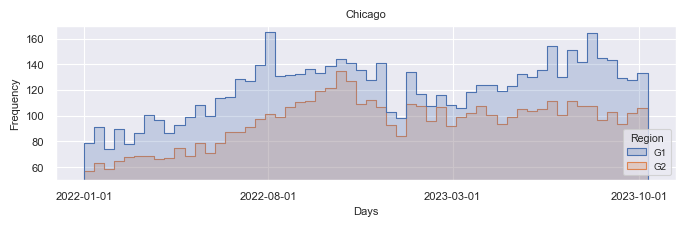

In [ ]:
# Import seaborn for enhanced statistical plotting.
import seaborn as sns
# Import matplotlib for plotting customization.
import matplotlib
# Create a figure with a specified size.
plt.figure(figsize=(10, 4))

# Update matplotlib parameters, specifically setting the default font size.
matplotlib.rcParams.update({'font.size': 12}) # NOTE: This font size might be large for final output elements.

# Define a color palette (tab10) and create a custom palette with two colors from it (commented out).
palette_tab10 = sns.color_palette("tab10", 10)
#custom_palette = [palette_tab10[1], palette_tab10[0]] # Commented out custom palette usage

# Apply seaborn's default theme.
sns.set_theme()
# Set the seaborn context to 'paper' with a font scale.
sns.set_context("paper", font_scale=0.8)

# Create a figure and axes for the histogram plot.
fig, ax = plt.subplots(figsize=(8, 2))

# Create a histogram plot using seaborn's histplot.
# Data source is gdf_chicago (assumed from previous cells).
# x="Times" plots frequency against the original timestamps.
# hue="Region" separates the data by the 'Region' column ('G1'/'G2').
# element="step" draws the histogram as steps.
# stat='frequency' plots the count of events in each bin.
# hue_order=['G1','G2'] specifies the order of hues.
# common_norm=False prevents normalization across hue categories.
# ax=ax specifies the axes to draw on.
ax=sns.histplot(gdf_chicago#.query("Region!=0") # Commented out query
             , x="Times"
             , hue="Region"
             , element="step"
             , stat='frequency'
             #, palette=custom_palette # Commented out custom palette usage
             #, height=3 # These are relplot arguments, not histplot
             #, aspect=2 # These are relplot arguments, not histplot
             , hue_order=['G1','G2']
             , common_norm=False
             , ax=ax)

#plt.xticks(['2024-01-01', '2024-04-01', '2024-07-01', '2024-10-01']) # Commented out alternative x-ticks

# Set specific tick locations for the x-axis using dates relevant to Chicago data range.
plt.xticks(['2022-01-01', '2022-08-01', '2023-03-01', '2023-10-01'])

# Move the legend to the lower right corner of the plot.
sns.move_legend(ax, "lower right")
# Set the main title of the plot.
plt.title("Chicago", y=1.05) # y adjusts the title position


# Display the plot (redundant with plt.show() below).
# plt.ylim(50, 170) # Setting y-limits
#g.fig.set_size_inches(8, 2) # This is a relplot argument, not for standard matplotlib figure/axes.

# Set the limits for the y-axis.
plt.ylim(50, 170)

# Set title, axis labels, and tick label font size for the axes object.
ax.set_title('Chicago', fontsize=8)          # Title of the plot
ax.set_xlabel('Days', fontsize=8)                     # X-axis label
ax.set_ylabel('Frequency', fontsize=8)                 # Y-axis label
ax.tick_params(axis='both', which='major', labelsize=8)  # Font size for axis ticks


# Save the figure to multiple file formats with specified resolution and bounding box.
# NOTE: Ensure the 'RESULTADOS/' directory exists before running this code.
plt.savefig('RESULTADOS/fig7b.svg',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig7b.png',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig7b.eps',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig7b.tiff',dpi=600,bbox_inches='tight')
# Display the plot.
plt.show()


### 11. Visualize Model Accuracy by Region and Percentage
This block uses the seaborn library to create a relational plot visualizing model accuracy across different percentages of the predicted area (up to 30%). The plot is faceted by model (Naive, KDE, SEPP) and uses color to distinguish between 'Group 1' (Unprotected) and 'Group 2' (Protected) regions.

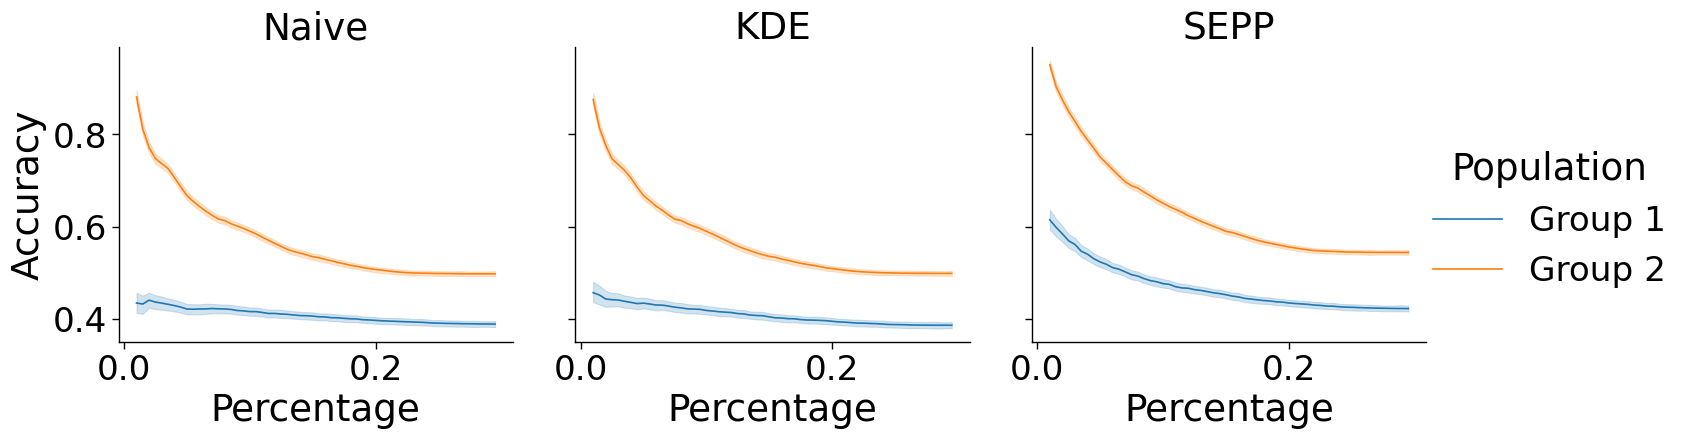

In [ ]:
# Import seaborn for enhanced statistical plotting.
import seaborn as sns
# Import matplotlib for plotting customization (already imported, but kept from original).
import matplotlib

# Note: Fairness_table is assumed to be loaded and processed in previous cells.

# Create a relational plot using seaborn's relplot.
# Data source is the filtered Fairness_table (Percentage <= 0.3).
# x="Percentage" maps the percentage of area to the x-axis.
# y="Accuracy" maps the accuracy value to the y-axis.
# hue="Population" colors the lines based on the 'Population' column ('Group 1'/'Group 2').
# kind="line" specifies a line plot.
# col="Model" creates separate columns (facets) for each model (Naive, KDE, SEPP).
# height=5 sets the height of each facet.
# aspect=1 sets the aspect ratio of each facet.
g=sns.relplot(data=Fairness_table.query("Percentage<=0.3") # Data source and filtering
            ,x="Percentage"
            ,y="Accuracy"
            ,hue="Population"
            ,kind="line"
            ,col="Model"
            ,height=5
            ,aspect=1)

# Customize the titles for each column (facet) using the model name.
g.set_titles(col_template="{col_name}")

# Display the plot.
plt.show()


### 12. Visualize Model Precision by Region and Percentage
This block uses the seaborn library to create a relational plot visualizing model precision across different percentages of the predicted area (up to 30%). The plot is faceted by population group ('Group 1' and 'Group 2') and uses color to distinguish between models (Naive, KDE, SEPP). The plot is customized with specific formatting and labels and saved to multiple image file formats.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


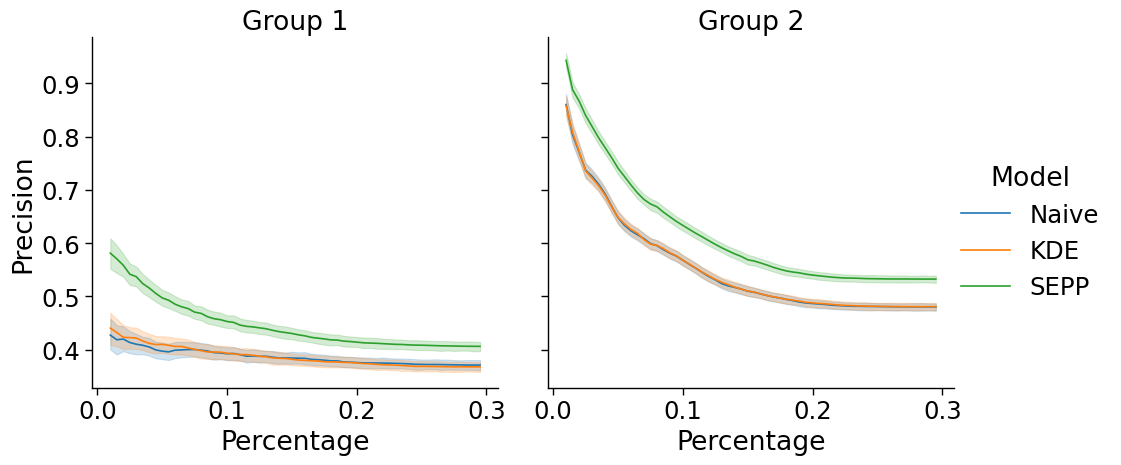

In [ ]:
# Import seaborn for enhanced statistical plotting.
import seaborn as sns
# Import matplotlib for plotting customization (already imported, but kept from original).
import matplotlib

# Note: Fairness_table is assumed to be loaded and processed in previous cells.
# Note: matplotlib.rcParams and sns.set_theme/context settings from previous cells are likely still active.

# Create a relational plot using seaborn's relplot.
# Data source is the filtered Fairness_table (Percentage <= 0.3).
# x="Percentage" maps the percentage of area to the x-axis.
# y="Precision" maps the precision value to the y-axis.
# hue="Model" colors the lines based on the 'Model' column (Naive, KDE, SEPP).
# kind="line" specifies a line plot.
# col="Population" creates separate columns (facets) for each population group ('Group 1'/'Group 2').
# height=5 sets the height of each facet.
# aspect=1 sets the aspect ratio of each facet.
g=sns.relplot(data=Fairness_table.query("Percentage<=0.3") # Data source and filtering
            ,x="Percentage"
            ,y="Precision" # Plotting Precision on the y-axis
            ,hue="Model" # Coloring lines by Model
            #,hue_order=['G1','G2'] # Removed hue_order as hue is now Model
            ,kind="line"
            ,col="Population" # Faceting by Population group
            ,height=5
            ,aspect=1
            #,facet_kws={'sharey': True} # facet_kws might be needed if y-axes should be shared
            #,legend='brief' # Legend is handled automatically by relplot with hue
            )

# Customize the titles for each column (facet) using the population group name.
g.set_titles(col_template="{col_name}")

# Save the figure to multiple file formats with specified resolution and bounding box.
# NOTE: Ensure the 'RESULTADOS/' directory exists before running this code.
# dpi=300 sets the resolution. bbox_inches='tight' tries to remove excess whitespace.
plt.savefig('RESULTADOS/FAIRNESS_PRECISION.svg',dpi=300,bbox_inches='tight')
plt.savefig('RESULTADOS/FAIRNESS_PRECISION.png',dpi=300,bbox_inches='tight')
plt.savefig('RESULTADOS/FAIRNESS_PRECISION.eps',dpi=300,bbox_inches='tight')
# plt.savefig('RESULTADOS/FAIRNESS_PRECISION.tiff',dpi=300,bbox_inches='tight') # TIFF format not included in original code

# Display the plot.
plt.show()
